The goal of this notebook is to detect the image tiles that contain tissue throughout. The result is a dictionary where each key is an image ID and the value is a list containing the IDs of the relevant tiles. Such a dictionary is created for each specified cycle and is saved as a txt file in the `out_dir` directory.

In [1]:
%matplotlib inline

from skimage import io
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import rescale_intensity

In [2]:
def rescale_image(img, min_quant=0, max_quant=0.99): 
    img = img * 1.0 # turn type to float before rescaling
    min_val = np.quantile(img, min_quant)
    max_val = np.quantile(img, max_quant)
    img = rescale_intensity(img, in_range=(min_val, max_val))
    return img


def get_border_stats(img, border=150, channel=2):
    # Make sure both single channel and multichannel images work
    if len(img.shape) == 3:
        img = img[..., channel]  # focus on one channel only
    # Get average intensity of all four border areas
    top_avg = np.average(img[0:border,:])
    left_avg = np.average(img[:, 0:border])
    bottom_avg = np.average(img[-border:, :])
    right_avg = np.average(img[:, -border:])
    averages = (top_avg, left_avg, bottom_avg, right_avg)
    # Get standard deviations
    top_var = np.var(img[0:border,:])
    left_var = np.var(img[:, 0:border])
    bottom_var = np.var(img[-border:, :])
    right_var = np.var(img[:, -border:])
    variances = (top_var, left_var, bottom_var, right_var)
    # Get and return ratios
    min_avg = np.min(averages)
    max_avg = np.max(averages)
    ratio_avg = min_avg/max_avg
    min_var = np.min(variances)
    max_var = np.max(variances)
    ratio_var = min_var/max_var
    return (ratio_avg, ratio_var, min_avg)


def get_corner_stats(img, channel=2, length=100):
    # Make sure both single channel and multichannel images work
    if len(img.shape) == 3:
        img = img[..., channel]  # focus on one channel only
    # Get average intensity of all four quarters
    top_right_avg = np.average(img[0:length,-length:])
    top_left_avg = np.average(img[0:length, 0:length])
    bottom_left_avg = np.average(img[-length:, 0:length])
    bottom_right_avg = np.average(img[-length:, -length:])
    averages = (top_right_avg, top_left_avg, bottom_left_avg, bottom_right_avg)
    # Get and return ratio
    min_avg = np.min(averages)
    max_avg = np.max(averages)
    ratio = min_avg/max_avg
    return ratio


def img_filter_bool(ratio_avg, ratio_var, ratio_corners, min_int, min_ratio_avg, min_ratio_var, min_ratio_corners, min_border_int):
    # If minimum intensity is below threshold return False
    if min_int < min_border_int:
        return False
    # If a ratio is too small return False
    if ratio_avg < min_ratio_avg:
        return False
    if ratio_var < min_ratio_var:
        return False
    if ratio_corners < min_ratio_corners:
        return False
    # If none of the statements above apply return True
    return True

Define input and output directory, the number of images (`n_points`), the number of tiles per image (`n_tiles`) and a list of cycle names (`cycles`)

In [3]:
# Path to images
img_dir = Path(r"/links/groups/treutlein/DATA/imaging/PW/4i/plate24/")
# Path to results folder
out_dir = Path(r"/links/groups/treutlein/USERS/pascal_noser/plate24_results/illumination_correction/tissue_tiles")
# Number of images and number of tiles per image
n_points = 60
n_tiles = 64
point_ids = ["{:04d}".format(i) for i in range(n_points)]
tile_ids = ["{:04d}".format(i) for i in range(n_tiles)]
cycles = ["cycle0"]  # so far only tried on one cycle

In order to detect image tiles that have tissue everywhere we will compare the average intensity of all four image border regions (width in pixels defined by `border`). If the lowest average intensity is not at least `min_ratio_avg` times the highest average intensity the image is kicked out. The same thing applies to variances and `min_ratio_var`. Furthermore, to also kick out images that show no tissue whatsoever, an intensity threshold `min_border_int` is defined. If one of the average intensities lies below this threshold the image is kicked out as well.  
A lot of the cases where this filtering fails have no tissue in a relatively small area in one corner of the tile. Because of this, the average intensity is determined for each corner (where the length of the bounding box is defined by `corner_len`) and once again the ratio between the lowest and highest value is taken. If this ratio is smaller than `min_ratio_corners` the tile is considered "bad".  
Even after doing this, there are still examples of images that aren't filtered out. For example, there are rare cases where there is a rather big hole somewhere on the tile. If the majority of this hole is not at the border it's not detected. Because of this, another filtering step is applied at the start where images that have a high amount of very low intensity pixels are filtered out as well. Which intensity is considered a "low intensity pixels" is defined by `low_int_thr` and the maximum fraction of such low intensity pixels is defined by `low_int_fraction_cutoff`.

In [5]:
# Width of border regions to check
border = 150
# Define minimum ratio of minimum average intensity/maximum average intensity borders
min_ratio_avg = 0.7
# Same with variances
min_ratio_var = 0.45
# Define minimum average border intensity to consider an image
min_border_int = 50
# Corner box side length
corner_len = 100
# Minimum ratio between average corner intensities
min_ratio_corners = 0.2
# Maximum allowed fraction of pixels with very low intensity
low_int_thr = 10
low_int_fraction_cutoff = 0.2

In [7]:
# create dictionary to keep track of which tiles are releavant for which point
filter_dict = dict.fromkeys(point_ids)
bad_dict = dict.fromkeys(point_ids)

# Load images
for cycle in cycles:
    print(cycle)
    cycle_dir = img_dir/cycle/"multichannel"
    for point in point_ids:
        print(point)
        tiles_good = []
        tiles_bad = []
        for tile in tile_ids:
            filename = "multichannel_Point{}_Point{}_ChannelSD 640,SD 488.tif".format(point, tile)
            img = io.imread(str(cycle_dir/filename))
            # Remove images with too many low intensity pixels
            low_int_fraction = np.count_nonzero(img[...,2]<low_int_thr)/img[...,2].size
            if low_int_fraction > low_int_fraction_cutoff:
                tiles_bad.append(tile)
                continue
            
            # Get border and corner stats
            ratio_avg, ratio_var, min_int = get_border_stats(img)
            ratio_corners = get_corner_stats(img)
            
            ## Filtering
            # Check if minimum intensity is below threshold
            if min_int < min_border_int:
                #tiles_bad.append(tile)
                continue
            # Check if a ratio is too small
            if ratio_avg < min_ratio_avg:
                #tiles_bad.append(tile)
                continue
            if ratio_var < min_ratio_var:
                #tiles_bad.append(tile)
                continue
            if ratio_corners < min_ratio_corners:
                #tiles_bad.append(tile)
                continue
            
            # If none of the above apply, add to "good" list
            tiles_good.append(tile)
        
        filter_dict[point] = tiles_good
        bad_dict[point] = tiles_bad
        print("Number of usable tiles: {}\n".format(len(tiles_good)))
    # Save dictionary as txt file
    out_file = "filtered_tiles_{}.txt".format(cycle)
    with open(out_dir/out_file, 'w') as f:
        print(filter_dict, file=f)

cycle0
0000
Number of usable tiles: 4

0001
Number of usable tiles: 5

0002
Number of usable tiles: 5

0003
Number of usable tiles: 6

0004
Number of usable tiles: 3

0005
Number of usable tiles: 4

0006
Number of usable tiles: 4

0007
Number of usable tiles: 5

0008
Number of usable tiles: 7

0009
Number of usable tiles: 4

0010
Number of usable tiles: 5

0011
Number of usable tiles: 2

0012
Number of usable tiles: 9

0013
Number of usable tiles: 8

0014
Number of usable tiles: 4

0015
Number of usable tiles: 2

0016
Number of usable tiles: 6

0017
Number of usable tiles: 5

0018
Number of usable tiles: 5

0019
Number of usable tiles: 3

0020
Number of usable tiles: 7

0021
Number of usable tiles: 6

0022
Number of usable tiles: 5

0023
Number of usable tiles: 5

0024
Number of usable tiles: 3

0025
Number of usable tiles: 3

0026
Number of usable tiles: 4

0027
Number of usable tiles: 7

0028
Number of usable tiles: 5

0029
Number of usable tiles: 5

0030
Number of usable tiles: 1

0

---  
### Checking filtered tiles

The cells below are for checking the filtered tiles. All the "good" tiles of a given ID are loaded and plotted. The tile number and various metrics that were used for filtering are shown as well.  
It is currently set up to run over all IDs. Just define the cycle in the cell below, run the cell once and then run the cell below that one to start with the first ID. Simply running that cell again will then show the tiles for the next ID and so on. Alternatively, the `point` variable can be manually defined if you want to have a look at a specific ID.

In [8]:
# Run only once!
i = -1
cycle = "cycle0"

ID: 0006
Number of tiles: 4


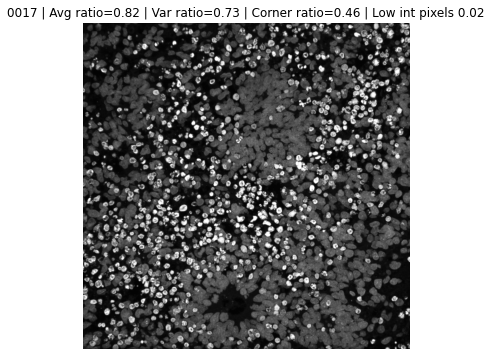

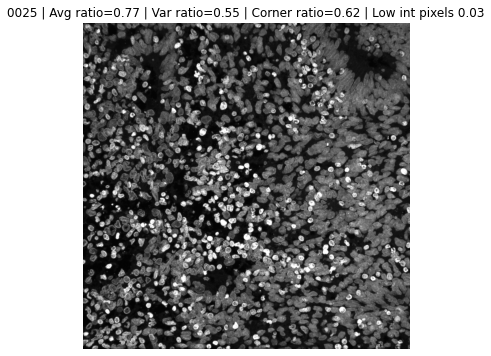

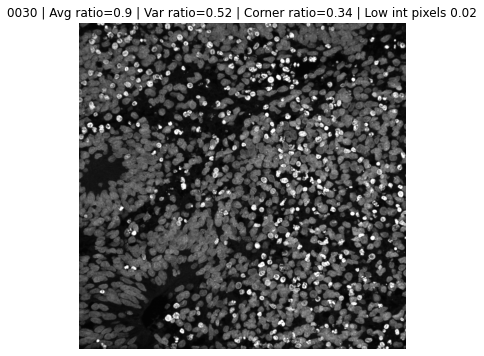

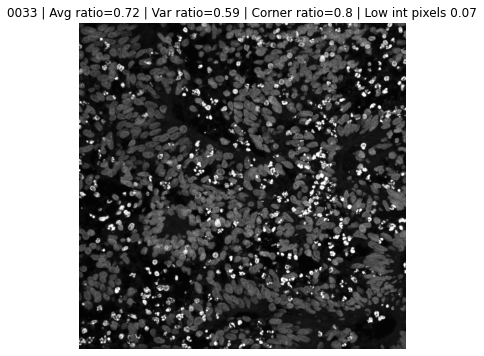

In [15]:
# Run this cell over and over to iterate over all IDs
i += 1
point = point_ids[i]
#point = "0033"
print("ID:", point)
print("Number of tiles:", len(filter_dict[point]))
for tile in filter_dict[point]:
    # Load images
    filename = "multichannel_Point{}_Point{}_ChannelSD 640,SD 488.tif".format(point, tile)
    img = io.imread(str(img_dir/cycle/"multichannel"/filename))
    # Stats
    ratio_avg, ratio_var, min_int = get_border_stats(img)
    ratio_corners = get_corner_stats(img)
    low_int_fraction = np.count_nonzero(img[...,2]<low_int_thr)/img[...,2].size
    #PLotting
    fig = plt.figure(figsize=(6,6))
    plt.imshow(rescale_image(img[...,2]), cmap="gray")
    plt.title("{} | Avg ratio={} | Var ratio={} | Corner ratio={} | Low int pixels {}".format(tile, np.round(ratio_avg,2), np.round(ratio_var,2),
                                                                                              np.round(ratio_corners, 2), np.round(low_int_fraction, 2)))
    plt.axis("off")